# Loading Dataset

In [1]:
import pandas as pd
import numpy as np

#Loading dataset
data = pd.read_csv('Downloads/eng_dataset.csv')

print(data.head())

#check setiment
print(data['sentiment'].value_counts())

      ID sentiment                                            content
0  10941     anger  At the point today where if someone says somet...
1  10942     anger  @CorningFootball  IT'S GAME DAY!!!!      T MIN...
2  10943     anger  This game has pissed me off more than any othe...
3  10944     anger  @spamvicious I've just found out it's Candice ...
4  10945     anger  @moocowward @mrsajhargreaves @Melly77 @GaryBar...
sentiment
fear       2252
anger      1701
joy        1616
sadness    1533
Name: count, dtype: int64


# Process Text Data

- Lowercase
- Remove URLs and domain suffixes
- Remove punctuation (!@#$%^&*()=-+[]{}\|`~/<>.,()?/)
- Remove repeated characters (eg: cooool -> cool)
- Remove non-alphabetic characters
- Remove extra white spaces
- Tokenization
- Remove stopwords (this, a, an, etc)
- Lemmatization ( grouping the inflected forms of same word)

In [2]:
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text (content):
    # Lowercase
    content = content.lower()

    # Remove URLs and domain suffixes
    content = ' '.join([
    word for word in content.split()
    if not any (sub in word for sub in ['http://', 'https://', '.com', '.es']) and word != 'rt'
    ])

    # Remove punctuation
    content = content.translate(str.maketrans('','',string.punctuation))

    # Remove repeated characters
    content = re.sub(r'(.)\1{3,}',r'\1',content)

    # Remove non-alphabetic characters
    content = re.sub(r'[^a-zA-Z]',' ',content)

    # Remove extra white spaces
    content = re.sub(r'\s+',' ',content.strip())

    # Tokenization
    tokens = word_tokenize(content)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [3]:
data['processed_content'] = data['content'].apply(preprocess_text)
print(data['processed_content'].head())

0    point today someone say something remotely kin...
1            corningfootball game day minus relentless
2    game pissed game year blood boiling time turn ...
3      spamvicious ive found candice candace pout like
4    moocowward mrsajhargreaves melly garybarlow ca...
Name: processed_content, dtype: object


# Exploratory Data Analysis

## Sentiment Distribution

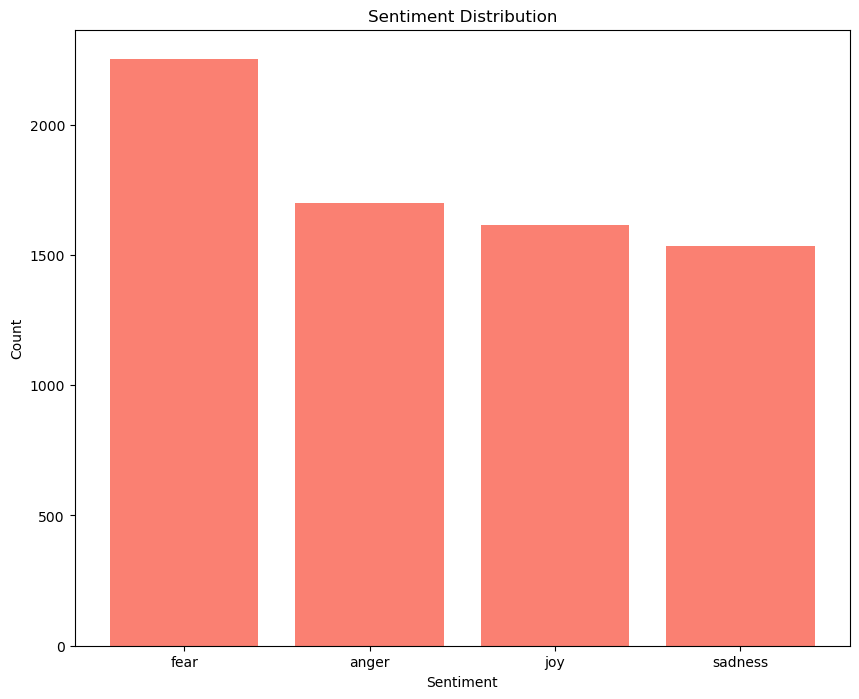

In [4]:
import matplotlib.pyplot as plt

# Sentiment Distribution
sentiment_counts = data.sentiment.value_counts()
plt.figure(figsize=(10,8))
plt.bar(sentiment_counts.index, sentiment_counts.values, color = 'salmon')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### Comment
The graph shows most of the reactions were identified as in fear sentiment. Not much of the difference among other 3 sentiments: anger, joy and sadness

## Counting words and letters

In [5]:
def count_letters_and_words(text):
    word_count = len(text.split())
    letter_count = sum(char.isalpha() for char in text)
    return letter_count, word_count

In [6]:
data['letter_count'], data['word_count'] = zip(*data['processed_content'].apply(count_letters_and_words))

## Number of words per sentiment class

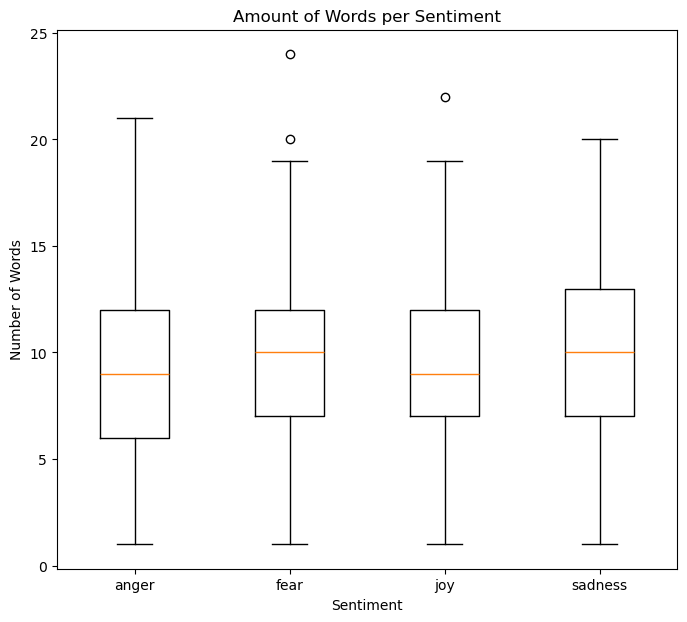

In [7]:
#Boxplot for amount of words per sentiment

grouped_data = data.groupby('sentiment')

fig, ax = plt.subplots(figsize = (8,7))
ax.boxplot([group['word_count'] for name, group in grouped_data],labels = grouped_data.groups.keys())
ax.set_title('Amount of Words per Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Words')
plt.show()


### Comment
According to the boxplot comparing the amount of words that people use to express their sentiments given the situation for anger, fear, joy and sadness.

Fear sentiment class had the highest median amount of words used, around 10 words per content, indicating that people tend to use more words to express their fear. The interquatile range (IQR) is relatively narrow (around 7 to 12 words) which suggests that most of the attended people use similar amounts. However, we also observe some outliers on the larger ends which may indicate that some people use more words to express their fear

With anger and sadness, we can see similar trend which contains slightly lower median than fear expression, but wider Interquartile Range, ranging from 6 to 12, 7 to 13 words in anger and sadness expression. This suggests more variation in the amount of words used to express the 2 sentiments - some utilise more words while others use far fewer.

When expressing joy sentiment, people tend to use fewer words explained by the fact that the median is lowest at around 8 words per content and the Interquartile Range is fairly narrow which also suggests that most of the attendees use fewer words to express their joy. The presence of outliers on the end may also indicate that some using more words to show their joy to the given situation.


## Number of Letters per Sentiment 

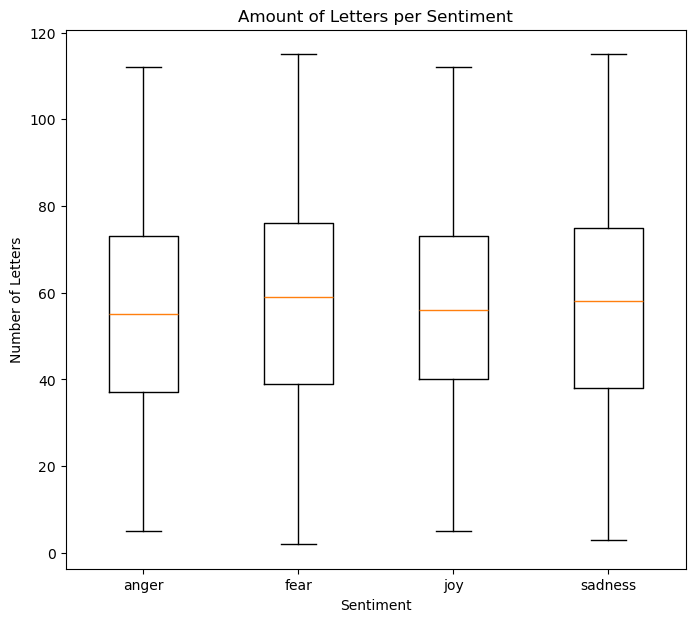

In [8]:
#Boxplot for average amount of letters per sentiment

fig, ax = plt.subplots(figsize=(8,7))
ax.boxplot([group['letter_count'] for name, group in grouped_data], labels= grouped_data.groups.keys())
ax.set_title('Amount of Letters per Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Letters')
plt.show()

### Comment

The amount of letters used in each sentiment does not have much difference of trend with the amount of words used in each content. In general, people tend to use more letters to express their fear and fewer letters to show their joy in the content

# Feature Extraction

In [9]:
data.drop(['ID'], axis = 1, inplace = True)
data.head()

,sentiment,content,processed_content,letter_count,word_count
0,anger,At the point today where if someone says somet...,point today someone say something remotely kin...,58,10
1,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,corningfootball game day minus relentless,37,5
2,anger,This game has pissed me off more than any othe...,game pissed game year blood boiling time turn ...,46,9
3,anger,@spamvicious I've just found out it's Candice ...,spamvicious ive found candice candace pout like,41,7
4,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,moocowward mrsajhargreaves melly garybarlow ca...,69,11


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 5000)
X = tfidf.fit_transform(data['processed_content']).toarray()
y = data['sentiment']  # Target labels

Use TF-IDF (Term Frequency - Invese Document Frequency) to convert text into numerical features

# Train Machine Learning Model

## Logistic Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 42)

#TRain model
model = LogisticRegression(max_iter=1000) #Increase iterations for convergence
model.fit(X_train, y_train)

#Predictions
y_pred= model.predict(X_test)

#Evaluate
print ('Accuracy:', accuracy_score(y_test, y_pred))
print (classification_report(y_test, y_pred))

Accuracy: 0.8698099929627023
              precision    recall  f1-score   support

       anger       0.92      0.83      0.88       375
        fear       0.79      0.94      0.86       434
         joy       0.95      0.89      0.92       319
     sadness       0.87      0.79      0.83       293

    accuracy                           0.87      1421
   macro avg       0.88      0.86      0.87      1421
weighted avg       0.88      0.87      0.87      1421



### Model Performance
The Logistic Regression model had correctly classified with 87% accuracy across 4 emotional stages: anger, fear, joy and sadness. It performs exceptionally well at detecting joy but highly sensitive to fear, capturing 94% of actual fear instances though occasionally misclassifyying other emotions as fear with the precision 79%. This suggests potential for improvement in distinguishing subtle cues.

# Testing

In [33]:
def predict_sentiment(text):
    processed_content = preprocess_text(text)
    vector = tfidf.transform([processed_content]).toarray()
    prediction = model.predict(vector)[0]
    return prediction

# Test
test_content = "I am so scared about this project!"
print("Predicted Sentiment:", predict_sentiment(test_content))  

Predicted Sentiment: fear


# Comment on this method

On this project I am using Term frequency - inverse document frequency as the embedding method which mainly counts word importance in a document which is good for simple model. However, the model won't be able to capture the context or word meaning which will lead to high chance of wrong predictions.

To improve the accuracy of predictions, it is suggested to try BERT/GPT (contectual Embeddings) embedding method with which words are embedded based on their context, so the word will have different vectors in different content. Yet, it is heavy and will requires GPu.

Another embedded method we should try is FastText which is suggested for informal text like social media.

In [34]:
import pandas as pd

# Add predictions to the original dataset
data['predicted_sentiment'] = model.predict(X)  # X is TF-IDF transformed data

# Save to CSV for Tableau/Power BI
data.to_csv("sentiment_predictions.csv", index=False)